# Projeto Final

Lucas Amin Kuttner
Rafael Hideo Toyomoto
William Henrique

In [13]:
import os
import glob
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import numpy as np

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda

In [5]:
# Reference for parameters:
# https://github.com/tranquanghuy0801/HandSegNet/blob/master/main.py

model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=2, padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=2, padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model.add(Conv2D(1, (1, 1), padding='same'))
model.add(UpSampling2D((4, 4)))

# Importing Keras in lambda function to prevent a bug
def lambda_argmax(x):
    from keras import backend
    return backend.softmax(x)

def lambda_cast(x):
    from keras import backend
    return backend.cast(x, "float")

# Argmax layer
# model.add(Lambda(lambda_argmax))
# model.add(Lambda(lambda_cast))

opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

model_name = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S.h5")
save_dir = os.path.join(os.getcwd(), 'saved_models')
model.save(os.path.join(save_dir, model_name))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 256)      

In [6]:
SAVED_MODEL_PATH = 'saved_models'
TRAINING_PATH = 'RHD_published_v2/training'
EVALUATE_PATH = 'RHD_published_v2/evaluation'

In [7]:
def get_latest_model():
    return max(glob.glob(SAVED_MODEL_PATH + "/*"), key=os.path.getctime)

def load_images(path: str, init: int = 0, size: int = None, shape=(256, 256)):
    X, y = [], []

    images_names = os.listdir(os.path.join(path, 'color'))
    if size is not None:
        images_names = images_names[init:size]
    else:
        images_names = images_names[init:]

    for idx, name in enumerate(images_names):

        image = cv2.imread(os.path.join(path, 'color', name))
        image = cv2.resize(image, shape)

        mask = cv2.imread(os.path.join(path, 'mask', name), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, shape).reshape((shape[0], shape[1], 1))
        mask = cv2.normalize(mask, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(image)
        y.append(mask)

        if idx % 500 == 0:
            print("%d of %d" % (idx, len(images_names)))

    return np.array(X), np.array(y)

In [8]:
# Training parameters
batch_size = 16
epochs = 6

In [9]:
print("Loading training dataset ...")
X_train, y_train = load_images(TRAINING_PATH, 0, 10000)
# X_train, y_train = load_images(TRAINING_PATH, 5000 * TIME, 5000 * (TIME + 1))
print("... done!")
print(X_train.shape, y_train.shape)

Loading training dataset ...
0 of 10000
500 of 10000
1000 of 10000
1500 of 10000
2000 of 10000
2500 of 10000
3000 of 10000
3500 of 10000
4000 of 10000
4500 of 10000
5000 of 10000
5500 of 10000
6000 of 10000
6500 of 10000
7000 of 10000
7500 of 10000
8000 of 10000
8500 of 10000
9000 of 10000
9500 of 10000
... done!
(10000, 256, 256, 3) (10000, 256, 256)


In [10]:
print("Loading evaluation dataset ...")
X_test, y_test = load_images(EVALUATE_PATH, 0, 500)
print("... done!")
print(X_test.shape, y_test.shape)

Loading evaluation dataset ...
0 of 500
... done!
(500, 256, 256, 3) (500, 256, 256)


In [11]:
model_name = get_latest_model()
model = load_model(model_name)
print('-' * 80)
print("Loaded model " + model_name)
# model.summary()

--------------------------------------------------------------------------------
Loaded model saved_models\2019-12-10-22-49-03.h5


In [ ]:
print('-' * 80)
print("Starting to train..")
start_time = time.time()
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test),
          shuffle=True)
print("Fitting duration: " + str(time.time() - start_time))

new_model_name = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S.h5")
model.save(os.path.join(SAVED_MODEL_PATH, new_model_name))
print("Saved model " + new_model_name)

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading evaluation dataset ...
0 of 1
... done!
(1, 256, 256, 3) (1, 256, 256)


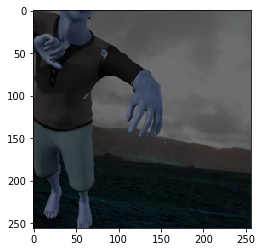

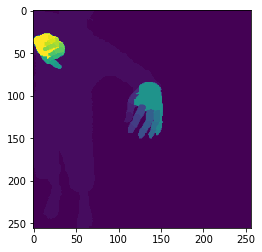

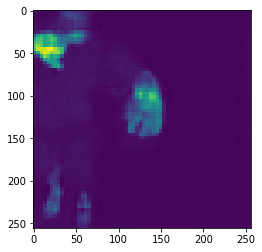

In [16]:
print("Loading evaluation dataset ...")
X_test, y_test = load_images(EVALUATE_PATH, 68, 69)
print("... done!")
print(X_test.shape, y_test.shape)

y_predict = model.predict(X_test)[0]
y_predict = cv2.normalize(y_predict, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

mask = cv2.normalize(y_test[0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.imshow(X_test[0])
plt.show()
plt.imshow(mask)
plt.show()
plt.imshow(y_predict)
plt.show()

Loading evaluation dataset ...
0 of 1
... done!
(1, 256, 256, 3) (1, 256, 256)


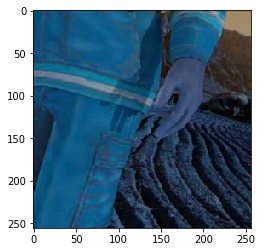

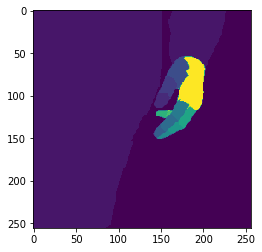

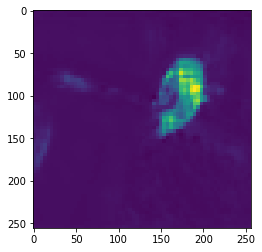

In [17]:
print("Loading evaluation dataset ...")
X_test, y_test = load_images(EVALUATE_PATH, 1278, 1279)
print("... done!")
print(X_test.shape, y_test.shape)

y_predict = model.predict(X_test)[0]
y_predict = cv2.normalize(y_predict, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

mask = cv2.normalize(y_test[0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.imshow(X_test[0])
plt.show()
plt.imshow(mask)
plt.show()
plt.imshow(y_predict)
plt.show()

Loading evaluation dataset ...
0 of 1
... done!
(1, 256, 256, 3) (1, 256, 256)


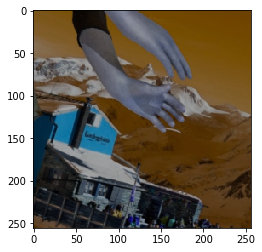

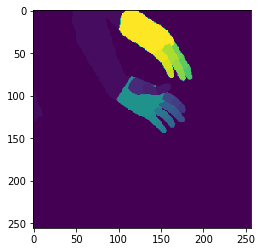

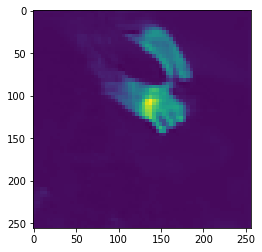

In [19]:
print("Loading evaluation dataset ...")
X_test, y_test = load_images(EVALUATE_PATH, 665, 666)
print("... done!")
print(X_test.shape, y_test.shape)

y_predict = model.predict(X_test)[0]
y_predict = cv2.normalize(y_predict, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

mask = cv2.normalize(y_test[0], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

plt.imshow(X_test[0])
plt.show()
plt.imshow(mask)
plt.show()
plt.imshow(y_predict)
plt.show()